In [1]:
# %load ../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path, LinearRegression

from pyuoi.linear_model import UoI_Lasso
from pyuoi.linear_model.adaptive import mBIC, eBIC, mBIC2, BIC, MIC

In [2]:
from sklearn.linear_model import lars_path

In [3]:
from sklearn.preprocessing import StandardScaler

In [12]:
# %load ../loaders/datgen.py
n_features = 50
n_samples = 200


# Iterate over sparsity. Yield a sequences of models using LARS. Choose a model using the various extensions 
# of the BIC. 

sparsity = np.linspace(0.05, 1, 11)
sigma = gen_covariance(n_features, 0, n_features, 5, 1)

oracle_penalty = np.zeros(sparsity.size)
MIC_oracle_sa = np.zeros(sparsity.size)

BIC_scores = []
mBIC_scores = []
eBIC_scores = []
mBIC2_scores = []

# Oracle sa
sa = []


for i, s in enumerate(sparsity):

    beta = gen_beta2(n_features, n_features, sparsity = s, betawidth = 0)
    X, X_test, y, y_test, ss = gen_data(n_samples, n_features, kappa = 3, 
                                        covariance = sigma, beta = beta)
    
    X = StandardScaler().fit_transform(X)
    y -= np.mean(y)
    
    _, _, coefs  = lars_path(X, y.ravel(), method = 'lasso')

    supports = (coefs.T != 0).astype(bool)

    # Stick the true model in there
    # supports = np.vstack([supports, (beta.ravel() !=0).astype(bool)])
    
    sa.append(selection_accuracy(beta.ravel(), supports))
        
    # Fit OLS models to each of the supports
    models = []

    penalties = np.linspace(0, 2 * np.log(n_samples), 80)
    MIC_scores_ = np.zeros((supports.shape[0], penalties.size))
    BIC_scores_ = np.zeros(supports.shape[0])
    mBIC_scores_ = np.zeros(supports.shape[0])
    eBIC_scores_ = np.zeros(supports.shape[0])
    mBIC2_scores_ = np.zeros(supports.shape[0])
    
    for j in range(supports.shape[0]):
        support = supports[j, :]
        if np.count_nonzero(1 * support > 0):
            model = LinearRegression().fit(X[:, support] , y)
            models.append(model)        
            y_pred = model.predict(X[:, support])

        else:
            models.append(np.nan)
            y_pred = np.zeros(y.size)
                        
        MIC_scores_[j, :] =  np.array([MIC(y, y_pred, np.count_nonzero(1 * support), penalty) 
                                       for penalty in penalties])
        
        BIC_scores_[j] = BIC(y, y_pred, np.count_nonzero(1 * support))
        
        mBIC_scores_[j] = mBIC(y, y_pred, np.count_nonzero(1 * support), s)
        
        eBIC_scores_[j] = eBIC(y, y_pred, X.shape[1], np.count_nonzero(1 * support))
        
        mBIC2_scores_[j] = mBIC2(y, y_pred, np.count_nonzero(1 * support), s)

    
    
    # For MIC scores, record the oracle selection accuracy and the oracle penalty
    selected_models = np.argmin(MIC_scores_, axis = 0)
    MIC_selection_accuracies = [selection_accuracy(beta.ravel(), supports[selected_models[j], :]) 
                                for j in range(selected_models.size)]
    oracle_penalty[i] = penalties[np.argmax(MIC_selection_accuracies)]
    MIC_oracle_sa[i] = np.max(MIC_selection_accuracies)    
    
    BIC_scores.append(BIC_scores_)
    mBIC_scores.append(mBIC_scores_)
    eBIC_scores.append(eBIC_scores_)
    mBIC2_scores.append(mBIC2_scores_)
    

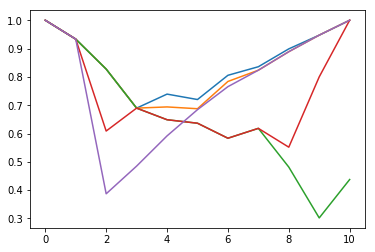

In [13]:
# Oracle sa
plt.plot([np.max(x) for x in sa])

plt.plot(MIC_oracle_sa)

# BIC sa
plt.plot([sa[i][np.argmin(BIC_scores[i])] for i in range(len(sparsity))])
# mBIC sa
plt.plot([sa[i][np.argmin(mBIC_scores[i])] for i in range(len(sparsity))])
# eBIC sa
# plt.plot([sa[i][np.argmin(eBIC_scores[i])] for i in range(len(sparsity))])
# mBIC2 sa
plt.plot([sa[i][np.argmin(mBIC2_scores[i])] for i in range(len(sparsity))])

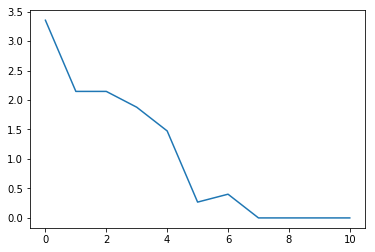

In [14]:
plt.plot(oracle_penalty)

In [6]:
# Now, estimate the sparsity !!!